Resumo dos Hiperparâmetros Utilizados (Experimento Final)
1. Parâmetros do Dataset e Treinamento
Arquitetura do Modelo: U-Net
Tamanho da Imagem: 256 x 256 pixels
Tamanho do Lote (Batch Size): 4 imagens por iteração
Número de Épocas (Epochs): 100 (duração máxima do treinamento)
2. Parâmetros de Otimização
Função de Perda (Loss Function): DiceBCELoss (uma combinação de Binary Cross-Entropy e Dice Loss, robusta para segmentação e classes desbalanceadas).
Otimizador (Optimizer): Adam
Taxa de Aprendizado Inicial (Initial Learning Rate): 1e-4 (ou 0.0001)
3. Parâmetros do Agendador de Taxa de Aprendizado (Learning Rate Scheduler)
Estratégia: ReduceLROnPlateau (Reduzir a taxa de aprendizado quando a métrica para de melhorar).
Métrica Monitorada: IoU de Validação (o scheduler age com base nesta métrica).
Fator de Redução: 0.2 (a nova taxa de aprendizado será antiga * 0.2).
Paciência (Patience): 5 épocas (número de épocas a esperar por uma melhora antes de reduzir a taxa de aprendizado).
Taxa de Aprendizado Mínima (Min LR): 1e-7 (o scheduler não reduzirá a taxa para valores abaixo deste).

In [1]:
# CELULA 1
# Importar as bibliotecas necessárias
import os
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import concurrent.futures
import csv
import pandas as pd
import seaborn as sns

In [2]:
# CELULA 2
# Defina os caminhos
SOURCE_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data"
TARGET_DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" # Nova pasta
TARGET_SIZE = (256, 256)

# print(f"Criando nova estrutura de pastas em: {TARGET_DATA_DIR}")
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "train/masks"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/images"), exist_ok=True)
# os.makedirs(os.path.join(TARGET_DATA_DIR, "validation/masks"), exist_ok=True)

# def process_single_image(args):
#     filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder = args
#     try:
#         with Image.open(os.path.join(source_img_folder, filename)) as img:
#             img_resized = img.resize(TARGET_SIZE, Image.LANCZOS)
#             img_resized.save(os.path.join(target_img_folder, filename))

#         mask_filename = filename.replace(".jpg", ".png")
#         mask_path = os.path.join(source_mask_folder, mask_filename)
#         if not os.path.exists(mask_path):
#             mask_path = os.path.join(source_mask_folder, filename) # Tenta o mesmo nome

#         with Image.open(mask_path) as mask:
#             mask_resized = mask.resize(TARGET_SIZE, Image.NEAREST)
#             mask_resized.save(os.path.join(target_mask_folder, mask_filename))
#     except Exception as e:
#         print(f"Erro ao processar {filename}: {e}")

# def preprocess_dataset(subset):
#     print(f"\nProcessando o conjunto de dados: {subset}")
#     source_img_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/images")
#     source_mask_folder = os.path.join(SOURCE_DATA_DIR, f"{subset}/masks")
#     target_img_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/images")
#     target_mask_folder = os.path.join(TARGET_DATA_DIR, f"{subset}/masks")
#     image_files = os.listdir(source_img_folder)

#     args_list = [
#         (filename, source_img_folder, source_mask_folder, target_img_folder, target_mask_folder)
#         for filename in image_files
#     ]

#     with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
#         list(tqdm(executor.map(process_single_image, args_list), total=len(args_list), desc=f"Redimensionando {subset} images"))

# # Executar para treino e validação
# preprocess_dataset("train")
# preprocess_dataset("validation")

# print("\nPré-processamento concluído!")

In [3]:
# CELULA 3
# --- Configurações do Ambiente e Caminhos ---
# Certifique-se de que este caminho aponta para os dados pré-processados
DATA_DIR = "C:/Mestrado/Materias/pesquisa/tomates/tomatotest/processed_data_256" 
MODEL_SAVE_PATH = "./tomato_unet_best.pth"  # O modelo será salvo com este nome
CSV_LOG_PATH = "./training_log.csv"      # O log será salvo aqui
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando o dispositivo: {DEVICE}")

# --- Hiperparâmetros para o Treinamento v2 ---
config = {
    "LEARNING_RATE": 1e-4,       # LR inicial. O scheduler vai ajustá-lo.
    "BATCH_SIZE": 4,
    "NUM_EPOCHS": 100,            
    "IMAGE_HEIGHT": 256,
    "IMAGE_WIDTH": 256,
    "OPTIMIZER": "Adam",
    "LOSS_FUNCTION": "DiceBCE"
}

# NOVO: Configuração do Agendador de Taxa de Aprendizado (Scheduler)
scheduler_config = {
    "factor": 0.2,               # Fator de redução do LR (new_lr = lr * factor). 0.1 ou 0.2 são comuns.
    "patience": 5,               # Nº de épocas sem melhora no val_iou para reduzir o LR.
    "min_lr": 1e-7,              # Taxa de aprendizado mínima.
    "verbose": True              # Imprime uma mensagem quando o LR é atualizado.
}

Usando o dispositivo: cuda


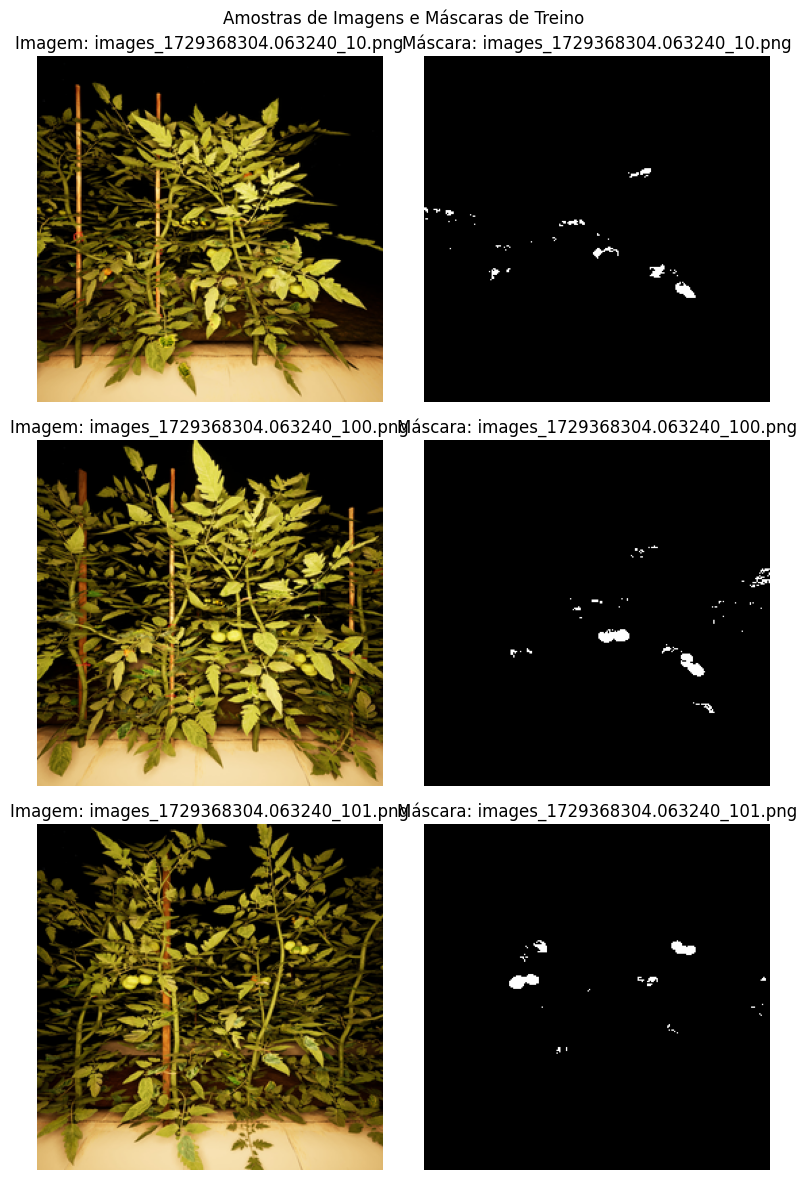

Analisando a proporção de pixels de 'tomate' nas máscaras de treino...


100%|██████████| 100/100 [00:00<00:00, 2949.02it/s]


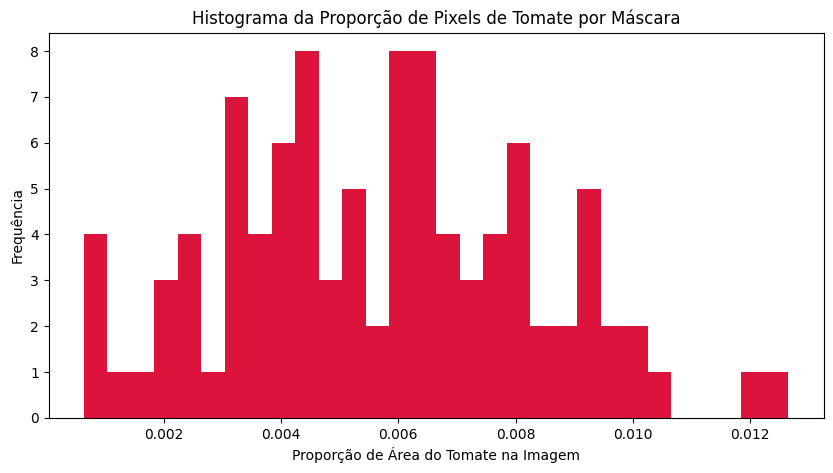

Análise concluída. Média da proporção (em imagens com tomates): 0.0057


In [4]:
# CELULA 4
# a) Pré-processamento, análise estatística dos dados, visualização

# Vamos visualizar algumas imagens e máscaras para entender os dados
train_img_dir = os.path.join(DATA_DIR, "train/images")
train_mask_dir = os.path.join(DATA_DIR, "train/masks")

# Pegar uma lista de imagens (assumindo que os nomes correspondem)
sample_images = os.listdir(train_img_dir)[:3]

fig, axs = plt.subplots(len(sample_images), 2, figsize=(8, 12))
fig.suptitle('Amostras de Imagens e Máscaras de Treino')

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(train_img_dir, img_name)
    # Assumindo que a máscara tem o mesmo nome, mas talvez extensão diferente
    # Tente .png ou .jpg se necessário
    mask_path = os.path.join(train_mask_dir, img_name.replace('.jpg', '.png'))
    if not os.path.exists(mask_path):
        mask_path = os.path.join(train_mask_dir, img_name)


    image = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L") # Converter para tons de cinza

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(f"Imagem: {img_name}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].set_title(f"Máscara: {os.path.basename(mask_path)}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Análise Estatística Simples: Proporção de pixels de tomate
print("Analisando a proporção de pixels de 'tomate' nas máscaras de treino...")
mask_files = os.listdir(train_mask_dir)
tomato_proportions = []
for mask_file in tqdm(mask_files[:100]): # Analisar as primeiras 100 para ser rápido
    mask_path = os.path.join(train_mask_dir, mask_file)
    mask_np = np.array(Image.open(mask_path).convert("L"))
    proportion = np.sum(mask_np > 128) / (mask_np.shape[0] * mask_np.shape[1])
    if proportion > 0: # Apenas se houver tomate
        tomato_proportions.append(proportion)

plt.figure(figsize=(10, 5))
plt.hist(tomato_proportions, bins=30, color='crimson')
plt.title('Histograma da Proporção de Pixels de Tomate por Máscara')
plt.xlabel('Proporção de Área do Tomate na Imagem')
plt.ylabel('Frequência')
plt.show()
print(f"Análise concluída. Média da proporção (em imagens com tomates): {np.mean(tomato_proportions):.4f}")

In [5]:
# CELULA 5
# Classe customizada para carregar os dados
class TomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.image_dir, img_name)

        # Tratar extensões diferentes entre imagem e máscara
        mask_name = img_name
        possible_mask_exts = ['.png', '.jpg', '.jpeg']
        for ext in possible_mask_exts:
            if mask_name.endswith(ext):
                base_name = mask_name[:-len(ext)]
                break
        else:
            base_name = mask_name

        mask_path = None
        for ext in possible_mask_exts:
            potential_path = os.path.join(self.mask_dir, base_name + ext)
            if os.path.exists(potential_path):
                mask_path = potential_path
                break

        if mask_path is None:
            # Tenta com o mesmo nome exato se falhar
             mask_path = os.path.join(self.mask_dir, img_name)
             if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem {img_name}")


        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

        # Normalizar máscara para 0.0-1.0
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

# Definir transformações (redimensionamento e conversão para tensor)
# Para data augmentation, pode-se usar a biblioteca Albumentations
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# Por simplicidade, usaremos torchvision transforms
NUM_WORKERS = 0 # <<<< COMECE COM ESTE VALOR

# --- Transformações ---
# Como você já pré-processou, não precisamos mais do Resize
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),
])


class CustomTomatoDataset(Dataset):
    def __init__(self, image_dir, mask_dir, img_transform, mask_transform):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        
        # Pega a lista de imagens e cria uma referência para as máscaras
        self.image_files = sorted(os.listdir(image_dir))
        
        # Verificação inicial: Checa se pelo menos a primeira máscara existe
        if len(self.image_files) > 0:
            self._verify_path(0)

    def __len__(self):
        return len(self.image_files)

    def _verify_path(self, index):
        """Função interna para encontrar o caminho correto da máscara."""
        img_name = self.image_files[index]
        base_name, _ = os.path.splitext(img_name)
        
        # Tenta as extensões mais comuns para máscaras
        possible_mask_names = [f"{base_name}.png", f"{base_name}.jpg", f"{base_name}.jpeg"]
        
        for mask_name in possible_mask_names:
            mask_path = os.path.join(self.mask_dir, mask_name)
            if os.path.exists(mask_path):
                return mask_path
        
        # Se não encontrar, levanta um erro claro
        raise FileNotFoundError(f"Não foi possível encontrar a máscara para a imagem '{img_name}'. "
                              f"Procurado por {possible_mask_names} na pasta {self.mask_dir}")

    def __getitem__(self, index):
        try:
            # Caminho da imagem
            img_path = os.path.join(self.image_dir, self.image_files[index])
            
            # Caminho da máscara (verificado pela função interna)
            mask_path = self._verify_path(index)
            
            # Carregar imagem e máscara
            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            # Aplicar transformações
            image = self.img_transform(image)
            mask = self.mask_transform(mask)
            
            # Binarizar a máscara para garantir 0s e 1s
            mask = (mask > 0.5).float()
            
            return image, mask

        except Exception as e:
            print(f"Erro ao carregar o item no índice {index}, arquivo: {self.image_files[index]}")
            # Retornar o erro para que o DataLoader possa lidar com ele (ou pular o item)
            raise e


# Criar Datasets
try:
    # ATENÇÃO: Verifique se o DATA_DIR está apontando para a pasta pré-processada (ex: .../processed_data_256)
    train_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "train/images"),
        mask_dir=os.path.join(DATA_DIR, "train/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    val_ds = CustomTomatoDataset(
        image_dir=os.path.join(DATA_DIR, "validation/images"),
        mask_dir=os.path.join(DATA_DIR, "validation/masks"),
        img_transform=data_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=config["BATCH_SIZE"],
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    print(f"Dataset de treino: {len(train_ds)} amostras.")
    print(f"Dataset de validação: {len(val_ds)} amostras.")
    print(f"DataLoader usando {NUM_WORKERS} workers.")

except Exception as e:
    print(f"Ocorreu um erro ao criar os datasets: {e}")

print(f"Dataset de treino: {len(train_ds)} amostras.")
print(f"Dataset de validação: {len(val_ds)} amostras.")

Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.
DataLoader usando 0 workers.
Dataset de treino: 17138 amostras.
Dataset de validação: 4229 amostras.


In [6]:
# CELULA 6
# Bloco de convolução dupla usado na U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

# Implementação da U-Net
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (Down path)
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder (Up path)
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Teste rápido para ver se a arquitetura está correta
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
x = torch.randn(2, 3, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"]).to(DEVICE)
preds = model(x)
assert preds.shape == (2, 1, config["IMAGE_HEIGHT"], config["IMAGE_WIDTH"])
print("Arquitetura U-Net carregada com sucesso!")

Arquitetura U-Net carregada com sucesso!


In [7]:
# CELULA 7
# Métrica 1: Dice Coefficient / F1 Score
# Essencial para artigos de segmentação
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs) # Aplicar sigmoid para ter probabilidades

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

# Métrica 2: Intersection over Union (IoU) / Jaccard Index
# Também essencial
def check_accuracy_and_get_metrics(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1) if len(y.shape) == 3 else y.to(device)

            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

            # Calcular Dice e IoU por lote e somar
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            dice_score += (2. * intersection) / ((preds + y).sum() + 1e-8)
            iou_score += intersection / (union + 1e-8)


    accuracy = num_correct/num_pixels*100
    avg_dice = dice_score/len(loader)
    avg_iou = iou_score/len(loader)

    print(f"Acurácia de pixels: {accuracy:.2f}%")
    print(f"Dice Score (Média): {avg_dice:.4f}")
    print(f"IoU/Jaccard (Média): {avg_iou:.4f}")

    model.train()
    return avg_iou, avg_dice

# Escolher a função de perda com base na configuração
if config["LOSS_FUNCTION"] == "BCE":
    loss_fn = nn.BCEWithLogitsLoss()
elif config["LOSS_FUNCTION"] == "Dice":
    loss_fn = DiceLoss()
elif config["LOSS_FUNCTION"] == "DiceBCE":
    class DiceBCELoss(nn.Module):
        def __init__(self, weight=None, size_average=True):
            super(DiceBCELoss, self).__init__()
        def forward(self, inputs, targets, smooth=1):
            inputs_sig = torch.sigmoid(inputs)
            inputs_flat = inputs_sig.view(-1)
            targets_flat = targets.view(-1)
            intersection = (inputs_flat * targets_flat).sum()
            dice_loss = 1 - (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
            bce = nn.BCEWithLogitsLoss()(inputs, targets)
            return bce + dice_loss
    loss_fn = DiceBCELoss()

# Escolher o otimizador
if config["OPTIMIZER"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
elif config["OPTIMIZER"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=config["LEARNING_RATE"], momentum=0.9)

print(f"Otimizador: {config['OPTIMIZER']}, Função de Perda: {config['LOSS_FUNCTION']}")

Otimizador: Adam, Função de Perda: DiceBCE


In [8]:
# CELULA 8
# Função para o loop de uma época
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        # Adicionar dimensão de canal para a máscara
        targets = targets.float().to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Update tqdm loop
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(loader)

# --- INÍCIO DO TREINAMENTO ---
history = {'train_loss': [], 'val_iou': [], 'val_dice': []}
best_val_iou = -1.0
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config["LEARNING_RATE"])
scaler = torch.cuda.amp.GradScaler()

# Instancia o Agendador de Taxa de Aprendizado
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'max', # Queremos maximizar o IoU
    factor=scheduler_config["factor"],
    patience=scheduler_config["patience"],
    min_lr=scheduler_config["min_lr"],
    verbose=scheduler_config["verbose"]
)

# --- INICIALIZAÇÃO DO LOG ---
best_val_iou = -1.0

# Cria o arquivo CSV e escreve o cabeçalho
with open(CSV_LOG_PATH, 'w', newline='') as f:
    writer = csv.writer(f)
    # MUDANÇA 1: Adicionada a coluna 'duration_sec' ao cabeçalho
    writer.writerow(['epoch', 'train_loss', 'val_iou', 'val_dice', 'learning_rate', 'duration_sec'])
print(f"Arquivo de log criado em: {CSV_LOG_PATH}")

# --- LOOP DE TREINAMENTO ---
print("\n--- Iniciando o Treinamento Final ---")
for epoch in range(config["NUM_EPOCHS"]):
    start_time = time.time()
    current_lr = optimizer.param_groups[0]['lr']
    
    model.train()
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

    model.eval()
    val_iou, val_dice = check_accuracy_and_get_metrics(val_loader, model, device=DEVICE)
    
    # Calcula a duração da época ANTES de imprimir, para poder salvar no log
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    # Imprime o resumo da época
    print(f"\n--- ÉPOCA {epoch+1}/{config['NUM_EPOCHS']} ---")
    print(f"Loss de Treino: {train_loss:.4f} | LR: {current_lr:.2e}")
    print(f"Validação -> IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")
    print(f"Duração da Época: {epoch_duration:.2f} segundos")

    scheduler.step(val_iou)

    # Salva os dados da época no arquivo CSV
    with open(CSV_LOG_PATH, 'a', newline='') as f:
        writer = csv.writer(f)
        # MUDANÇA 2: Adicionada a variável epoch_duration à linha salva
        writer.writerow([epoch+1, train_loss, val_iou.item(), val_dice.item(), current_lr, epoch_duration])

    # Salva o melhor modelo
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"** Novo melhor IoU: {best_val_iou:.4f}. Modelo salvo! **")

print("--- Treinamento Concluído ---")


Arquivo de log criado em: ./training_log.csv

--- Iniciando o Treinamento Final ---


100%|██████████| 4285/4285 [07:54<00:00,  9.03it/s, loss=0.276]


Acurácia de pixels: 99.70%
Dice Score (Média): 0.7204
IoU/Jaccard (Média): 0.5755

--- ÉPOCA 1/100 ---
Loss de Treino: 0.6098 | LR: 1.00e-04
Validação -> IoU: 0.5755 | Dice: 0.7204
Duração da Época: 526.07 segundos
** Novo melhor IoU: 0.5755. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.14it/s, loss=0.153]


Acurácia de pixels: 99.76%
Dice Score (Média): 0.7790
IoU/Jaccard (Média): 0.6468

--- ÉPOCA 2/100 ---
Loss de Treino: 0.2668 | LR: 1.00e-04
Validação -> IoU: 0.6468 | Dice: 0.7790
Duração da Época: 520.27 segundos
** Novo melhor IoU: 0.6468. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.186] 


Acurácia de pixels: 99.76%
Dice Score (Média): 0.7934
IoU/Jaccard (Média): 0.6652

--- ÉPOCA 3/100 ---
Loss de Treino: 0.2327 | LR: 1.00e-04
Validação -> IoU: 0.6652 | Dice: 0.7934
Duração da Época: 520.09 segundos
** Novo melhor IoU: 0.6652. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.29]  


Acurácia de pixels: 99.79%
Dice Score (Média): 0.8107
IoU/Jaccard (Média): 0.6878

--- ÉPOCA 4/100 ---
Loss de Treino: 0.2138 | LR: 1.00e-04
Validação -> IoU: 0.6878 | Dice: 0.8107
Duração da Época: 520.37 segundos
** Novo melhor IoU: 0.6878. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.13]  


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8231
IoU/Jaccard (Média): 0.7039

--- ÉPOCA 5/100 ---
Loss de Treino: 0.2001 | LR: 1.00e-04
Validação -> IoU: 0.7039 | Dice: 0.8231
Duração da Época: 520.51 segundos
** Novo melhor IoU: 0.7039. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.265] 


Acurácia de pixels: 99.80%
Dice Score (Média): 0.8294
IoU/Jaccard (Média): 0.7124

--- ÉPOCA 6/100 ---
Loss de Treino: 0.1897 | LR: 1.00e-04
Validação -> IoU: 0.7124 | Dice: 0.8294
Duração da Época: 520.39 segundos
** Novo melhor IoU: 0.7124. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.151] 


Acurácia de pixels: 99.81%
Dice Score (Média): 0.8363
IoU/Jaccard (Média): 0.7224

--- ÉPOCA 7/100 ---
Loss de Treino: 0.1814 | LR: 1.00e-04
Validação -> IoU: 0.7224 | Dice: 0.8363
Duração da Época: 520.46 segundos
** Novo melhor IoU: 0.7224. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.16]  


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8411
IoU/Jaccard (Média): 0.7293

--- ÉPOCA 8/100 ---
Loss de Treino: 0.1747 | LR: 1.00e-04
Validação -> IoU: 0.7293 | Dice: 0.8411
Duração da Época: 520.60 segundos
** Novo melhor IoU: 0.7293. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.14it/s, loss=0.343] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8467
IoU/Jaccard (Média): 0.7373

--- ÉPOCA 9/100 ---
Loss de Treino: 0.1683 | LR: 1.00e-04
Validação -> IoU: 0.7373 | Dice: 0.8467
Duração da Época: 520.32 segundos
** Novo melhor IoU: 0.7373. Modelo salvo! **


100%|██████████| 4285/4285 [07:50<00:00,  9.11it/s, loss=0.343] 


Acurácia de pixels: 99.82%
Dice Score (Média): 0.8498
IoU/Jaccard (Média): 0.7415

--- ÉPOCA 10/100 ---
Loss de Treino: 0.1639 | LR: 1.00e-04
Validação -> IoU: 0.7415 | Dice: 0.8498
Duração da Época: 522.95 segundos
** Novo melhor IoU: 0.7415. Modelo salvo! **


100%|██████████| 4285/4285 [07:54<00:00,  9.04it/s, loss=0.124] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8526
IoU/Jaccard (Média): 0.7459

--- ÉPOCA 11/100 ---
Loss de Treino: 0.1588 | LR: 1.00e-04
Validação -> IoU: 0.7459 | Dice: 0.8526
Duração da Época: 525.43 segundos
** Novo melhor IoU: 0.7459. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.147] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8562
IoU/Jaccard (Média): 0.7511

--- ÉPOCA 12/100 ---
Loss de Treino: 0.1556 | LR: 1.00e-04
Validação -> IoU: 0.7511 | Dice: 0.8562
Duração da Época: 520.69 segundos
** Novo melhor IoU: 0.7511. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.366] 


Acurácia de pixels: 99.83%
Dice Score (Média): 0.8585
IoU/Jaccard (Média): 0.7545

--- ÉPOCA 13/100 ---
Loss de Treino: 0.1516 | LR: 1.00e-04
Validação -> IoU: 0.7545 | Dice: 0.8585
Duração da Época: 520.77 segundos
** Novo melhor IoU: 0.7545. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.13]  


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8606
IoU/Jaccard (Média): 0.7577

--- ÉPOCA 14/100 ---
Loss de Treino: 0.1481 | LR: 1.00e-04
Validação -> IoU: 0.7577 | Dice: 0.8606
Duração da Época: 520.10 segundos
** Novo melhor IoU: 0.7577. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.151] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8625
IoU/Jaccard (Média): 0.7605

--- ÉPOCA 15/100 ---
Loss de Treino: 0.1451 | LR: 1.00e-04
Validação -> IoU: 0.7605 | Dice: 0.8625
Duração da Época: 519.93 segundos
** Novo melhor IoU: 0.7605. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.219] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8646
IoU/Jaccard (Média): 0.7638

--- ÉPOCA 16/100 ---
Loss de Treino: 0.1423 | LR: 1.00e-04
Validação -> IoU: 0.7638 | Dice: 0.8646
Duração da Época: 520.02 segundos
** Novo melhor IoU: 0.7638. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.15it/s, loss=0.285] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8662
IoU/Jaccard (Média): 0.7662

--- ÉPOCA 17/100 ---
Loss de Treino: 0.1394 | LR: 1.00e-04
Validação -> IoU: 0.7662 | Dice: 0.8662
Duração da Época: 519.74 segundos
** Novo melhor IoU: 0.7662. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.15it/s, loss=0.174] 


Acurácia de pixels: 99.84%
Dice Score (Média): 0.8677
IoU/Jaccard (Média): 0.7685

--- ÉPOCA 18/100 ---
Loss de Treino: 0.1371 | LR: 1.00e-04
Validação -> IoU: 0.7685 | Dice: 0.8677
Duração da Época: 519.80 segundos
** Novo melhor IoU: 0.7685. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.114] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8696
IoU/Jaccard (Média): 0.7714

--- ÉPOCA 19/100 ---
Loss de Treino: 0.1346 | LR: 1.00e-04
Validação -> IoU: 0.7714 | Dice: 0.8696
Duração da Época: 520.44 segundos
** Novo melhor IoU: 0.7714. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.125] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8710
IoU/Jaccard (Média): 0.7735

--- ÉPOCA 20/100 ---
Loss de Treino: 0.1326 | LR: 1.00e-04
Validação -> IoU: 0.7735 | Dice: 0.8710
Duração da Época: 520.34 segundos
** Novo melhor IoU: 0.7735. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.13it/s, loss=0.101] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8720
IoU/Jaccard (Média): 0.7751

--- ÉPOCA 21/100 ---
Loss de Treino: 0.1300 | LR: 1.00e-04
Validação -> IoU: 0.7751 | Dice: 0.8720
Duração da Época: 520.47 segundos
** Novo melhor IoU: 0.7751. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.156] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8730
IoU/Jaccard (Média): 0.7767

--- ÉPOCA 22/100 ---
Loss de Treino: 0.1285 | LR: 1.00e-04
Validação -> IoU: 0.7767 | Dice: 0.8730
Duração da Época: 520.07 segundos
** Novo melhor IoU: 0.7767. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.0863]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8748
IoU/Jaccard (Média): 0.7794

--- ÉPOCA 23/100 ---
Loss de Treino: 0.1260 | LR: 1.00e-04
Validação -> IoU: 0.7794 | Dice: 0.8748
Duração da Época: 519.94 segundos
** Novo melhor IoU: 0.7794. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.257] 


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8758
IoU/Jaccard (Média): 0.7810

--- ÉPOCA 24/100 ---
Loss de Treino: 0.1244 | LR: 1.00e-04
Validação -> IoU: 0.7810 | Dice: 0.8758
Duração da Época: 520.01 segundos
** Novo melhor IoU: 0.7810. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.0801]


Acurácia de pixels: 99.85%
Dice Score (Média): 0.8766
IoU/Jaccard (Média): 0.7824

--- ÉPOCA 25/100 ---
Loss de Treino: 0.1225 | LR: 1.00e-04
Validação -> IoU: 0.7824 | Dice: 0.8766
Duração da Época: 519.86 segundos
** Novo melhor IoU: 0.7824. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.105] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8779
IoU/Jaccard (Média): 0.7844

--- ÉPOCA 26/100 ---
Loss de Treino: 0.1206 | LR: 1.00e-04
Validação -> IoU: 0.7844 | Dice: 0.8779
Duração da Época: 520.20 segundos
** Novo melhor IoU: 0.7844. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.115] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8787
IoU/Jaccard (Média): 0.7856

--- ÉPOCA 27/100 ---
Loss de Treino: 0.1190 | LR: 1.00e-04
Validação -> IoU: 0.7856 | Dice: 0.8787
Duração da Época: 519.87 segundos
** Novo melhor IoU: 0.7856. Modelo salvo! **


100%|██████████| 4285/4285 [07:49<00:00,  9.14it/s, loss=0.0967]


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8796
IoU/Jaccard (Média): 0.7870

--- ÉPOCA 28/100 ---
Loss de Treino: 0.1172 | LR: 1.00e-04
Validação -> IoU: 0.7870 | Dice: 0.8796
Duração da Época: 520.28 segundos
** Novo melhor IoU: 0.7870. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.0674]


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8803
IoU/Jaccard (Média): 0.7882

--- ÉPOCA 29/100 ---
Loss de Treino: 0.1161 | LR: 1.00e-04
Validação -> IoU: 0.7882 | Dice: 0.8803
Duração da Época: 519.95 segundos
** Novo melhor IoU: 0.7882. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.316] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8803
IoU/Jaccard (Média): 0.7882

--- ÉPOCA 30/100 ---
Loss de Treino: 0.1144 | LR: 1.00e-04
Validação -> IoU: 0.7882 | Dice: 0.8803
Duração da Época: 520.17 segundos


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.101] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8818
IoU/Jaccard (Média): 0.7906

--- ÉPOCA 31/100 ---
Loss de Treino: 0.1129 | LR: 1.00e-04
Validação -> IoU: 0.7906 | Dice: 0.8818
Duração da Época: 520.05 segundos
** Novo melhor IoU: 0.7906. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.143] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8828
IoU/Jaccard (Média): 0.7922

--- ÉPOCA 32/100 ---
Loss de Treino: 0.1113 | LR: 1.00e-04
Validação -> IoU: 0.7922 | Dice: 0.8828
Duração da Época: 519.86 segundos
** Novo melhor IoU: 0.7922. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.111] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8837
IoU/Jaccard (Média): 0.7936

--- ÉPOCA 33/100 ---
Loss de Treino: 0.1099 | LR: 1.00e-04
Validação -> IoU: 0.7936 | Dice: 0.8837
Duração da Época: 520.69 segundos
** Novo melhor IoU: 0.7936. Modelo salvo! **


100%|██████████| 4285/4285 [07:46<00:00,  9.18it/s, loss=0.131] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8843
IoU/Jaccard (Média): 0.7946

--- ÉPOCA 34/100 ---
Loss de Treino: 0.1089 | LR: 1.00e-04
Validação -> IoU: 0.7946 | Dice: 0.8843
Duração da Época: 518.68 segundos
** Novo melhor IoU: 0.7946. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.0599]


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8847
IoU/Jaccard (Média): 0.7952

--- ÉPOCA 35/100 ---
Loss de Treino: 0.1076 | LR: 1.00e-04
Validação -> IoU: 0.7952 | Dice: 0.8847
Duração da Época: 520.91 segundos
** Novo melhor IoU: 0.7952. Modelo salvo! **


100%|██████████| 4285/4285 [07:50<00:00,  9.11it/s, loss=0.113] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8852
IoU/Jaccard (Média): 0.7962

--- ÉPOCA 36/100 ---
Loss de Treino: 0.1065 | LR: 1.00e-04
Validação -> IoU: 0.7962 | Dice: 0.8852
Duração da Época: 522.40 segundos
** Novo melhor IoU: 0.7962. Modelo salvo! **


100%|██████████| 4285/4285 [08:00<00:00,  8.91it/s, loss=0.086] 


Acurácia de pixels: 99.86%
Dice Score (Média): 0.8860
IoU/Jaccard (Média): 0.7974

--- ÉPOCA 37/100 ---
Loss de Treino: 0.1055 | LR: 1.00e-04
Validação -> IoU: 0.7974 | Dice: 0.8860
Duração da Época: 531.44 segundos
** Novo melhor IoU: 0.7974. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.122] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8863
IoU/Jaccard (Média): 0.7979

--- ÉPOCA 38/100 ---
Loss de Treino: 0.1041 | LR: 1.00e-04
Validação -> IoU: 0.7979 | Dice: 0.8863
Duração da Época: 513.19 segundos
** Novo melhor IoU: 0.7979. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.0985]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8866
IoU/Jaccard (Média): 0.7984

--- ÉPOCA 39/100 ---
Loss de Treino: 0.1031 | LR: 1.00e-04
Validação -> IoU: 0.7984 | Dice: 0.8866
Duração da Época: 513.43 segundos
** Novo melhor IoU: 0.7984. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.104] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8877
IoU/Jaccard (Média): 0.8001

--- ÉPOCA 40/100 ---
Loss de Treino: 0.1019 | LR: 1.00e-04
Validação -> IoU: 0.8001 | Dice: 0.8877
Duração da Época: 513.32 segundos
** Novo melhor IoU: 0.8001. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.0553]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8882
IoU/Jaccard (Média): 0.8010

--- ÉPOCA 41/100 ---
Loss de Treino: 0.1012 | LR: 1.00e-04
Validação -> IoU: 0.8010 | Dice: 0.8882
Duração da Época: 513.31 segundos
** Novo melhor IoU: 0.8010. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.0999]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8887
IoU/Jaccard (Média): 0.8019

--- ÉPOCA 42/100 ---
Loss de Treino: 0.1003 | LR: 1.00e-04
Validação -> IoU: 0.8019 | Dice: 0.8887
Duração da Época: 513.44 segundos
** Novo melhor IoU: 0.8019. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.122] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8892
IoU/Jaccard (Média): 0.8027

--- ÉPOCA 43/100 ---
Loss de Treino: 0.0992 | LR: 1.00e-04
Validação -> IoU: 0.8027 | Dice: 0.8892
Duração da Época: 513.70 segundos
** Novo melhor IoU: 0.8027. Modelo salvo! **


100%|██████████| 4285/4285 [07:45<00:00,  9.21it/s, loss=0.0759]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8888
IoU/Jaccard (Média): 0.8021

--- ÉPOCA 44/100 ---
Loss de Treino: 0.0984 | LR: 1.00e-04
Validação -> IoU: 0.8021 | Dice: 0.8888
Duração da Época: 515.56 segundos


100%|██████████| 4285/4285 [07:47<00:00,  9.16it/s, loss=0.105] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8902
IoU/Jaccard (Média): 0.8044

--- ÉPOCA 45/100 ---
Loss de Treino: 0.0974 | LR: 1.00e-04
Validação -> IoU: 0.8044 | Dice: 0.8902
Duração da Época: 518.13 segundos
** Novo melhor IoU: 0.8044. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.123] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8912
IoU/Jaccard (Média): 0.8059

--- ÉPOCA 46/100 ---
Loss de Treino: 0.0967 | LR: 1.00e-04
Validação -> IoU: 0.8059 | Dice: 0.8912
Duração da Época: 513.36 segundos
** Novo melhor IoU: 0.8059. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.0965]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8912
IoU/Jaccard (Média): 0.8059

--- ÉPOCA 47/100 ---
Loss de Treino: 0.0958 | LR: 1.00e-04
Validação -> IoU: 0.8059 | Dice: 0.8912
Duração da Época: 513.19 segundos


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.08]  


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8904
IoU/Jaccard (Média): 0.8047

--- ÉPOCA 48/100 ---
Loss de Treino: 0.0951 | LR: 1.00e-04
Validação -> IoU: 0.8047 | Dice: 0.8904
Duração da Época: 513.32 segundos


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.155] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8920
IoU/Jaccard (Média): 0.8073

--- ÉPOCA 49/100 ---
Loss de Treino: 0.0941 | LR: 1.00e-04
Validação -> IoU: 0.8073 | Dice: 0.8920
Duração da Época: 513.30 segundos
** Novo melhor IoU: 0.8073. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0335]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8923
IoU/Jaccard (Média): 0.8078

--- ÉPOCA 50/100 ---
Loss de Treino: 0.0937 | LR: 1.00e-04
Validação -> IoU: 0.8078 | Dice: 0.8923
Duração da Época: 513.90 segundos
** Novo melhor IoU: 0.8078. Modelo salvo! **


100%|██████████| 4285/4285 [07:46<00:00,  9.18it/s, loss=0.0704]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8925
IoU/Jaccard (Média): 0.8081

--- ÉPOCA 51/100 ---
Loss de Treino: 0.0929 | LR: 1.00e-04
Validação -> IoU: 0.8081 | Dice: 0.8925
Duração da Época: 519.38 segundos
** Novo melhor IoU: 0.8081. Modelo salvo! **


100%|██████████| 4285/4285 [08:04<00:00,  8.84it/s, loss=0.0935]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8928
IoU/Jaccard (Média): 0.8086

--- ÉPOCA 52/100 ---
Loss de Treino: 0.0923 | LR: 1.00e-04
Validação -> IoU: 0.8086 | Dice: 0.8928
Duração da Época: 535.55 segundos
** Novo melhor IoU: 0.8086. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0708]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8934
IoU/Jaccard (Média): 0.8096

--- ÉPOCA 53/100 ---
Loss de Treino: 0.0916 | LR: 1.00e-04
Validação -> IoU: 0.8096 | Dice: 0.8934
Duração da Época: 514.29 segundos
** Novo melhor IoU: 0.8096. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.0729]


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8938
IoU/Jaccard (Média): 0.8102

--- ÉPOCA 54/100 ---
Loss de Treino: 0.0907 | LR: 1.00e-04
Validação -> IoU: 0.8102 | Dice: 0.8938
Duração da Época: 513.45 segundos
** Novo melhor IoU: 0.8102. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.126] 


Acurácia de pixels: 99.87%
Dice Score (Média): 0.8939
IoU/Jaccard (Média): 0.8104

--- ÉPOCA 55/100 ---
Loss de Treino: 0.0902 | LR: 1.00e-04
Validação -> IoU: 0.8104 | Dice: 0.8939
Duração da Época: 513.52 segundos
** Novo melhor IoU: 0.8104. Modelo salvo! **


100%|██████████| 4285/4285 [07:42<00:00,  9.26it/s, loss=0.131] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8947
IoU/Jaccard (Média): 0.8118

--- ÉPOCA 56/100 ---
Loss de Treino: 0.0895 | LR: 1.00e-04
Validação -> IoU: 0.8118 | Dice: 0.8947
Duração da Época: 513.52 segundos
** Novo melhor IoU: 0.8118. Modelo salvo! **


100%|██████████| 4285/4285 [07:47<00:00,  9.17it/s, loss=0.0912]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8950
IoU/Jaccard (Média): 0.8123

--- ÉPOCA 57/100 ---
Loss de Treino: 0.0892 | LR: 1.00e-04
Validação -> IoU: 0.8123 | Dice: 0.8950
Duração da Época: 518.52 segundos
** Novo melhor IoU: 0.8123. Modelo salvo! **


100%|██████████| 4285/4285 [07:47<00:00,  9.17it/s, loss=0.122] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8947
IoU/Jaccard (Média): 0.8119

--- ÉPOCA 58/100 ---
Loss de Treino: 0.0886 | LR: 1.00e-04
Validação -> IoU: 0.8119 | Dice: 0.8947
Duração da Época: 517.71 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.111] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8953
IoU/Jaccard (Média): 0.8128

--- ÉPOCA 59/100 ---
Loss de Treino: 0.0881 | LR: 1.00e-04
Validação -> IoU: 0.8128 | Dice: 0.8953
Duração da Época: 514.32 segundos
** Novo melhor IoU: 0.8128. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0902]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8954
IoU/Jaccard (Média): 0.8129

--- ÉPOCA 60/100 ---
Loss de Treino: 0.0874 | LR: 1.00e-04
Validação -> IoU: 0.8129 | Dice: 0.8954
Duração da Época: 513.84 segundos
** Novo melhor IoU: 0.8129. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.073] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8956
IoU/Jaccard (Média): 0.8133

--- ÉPOCA 61/100 ---
Loss de Treino: 0.0868 | LR: 1.00e-04
Validação -> IoU: 0.8133 | Dice: 0.8956
Duração da Época: 514.96 segundos
** Novo melhor IoU: 0.8133. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.109] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8960
IoU/Jaccard (Média): 0.8139

--- ÉPOCA 62/100 ---
Loss de Treino: 0.0861 | LR: 1.00e-04
Validação -> IoU: 0.8139 | Dice: 0.8960
Duração da Época: 513.95 segundos
** Novo melhor IoU: 0.8139. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.149] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8964
IoU/Jaccard (Média): 0.8147

--- ÉPOCA 63/100 ---
Loss de Treino: 0.0856 | LR: 1.00e-04
Validação -> IoU: 0.8147 | Dice: 0.8964
Duração da Época: 514.11 segundos
** Novo melhor IoU: 0.8147. Modelo salvo! **


100%|██████████| 4285/4285 [07:46<00:00,  9.18it/s, loss=0.0796]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8965
IoU/Jaccard (Média): 0.8149

--- ÉPOCA 64/100 ---
Loss de Treino: 0.0854 | LR: 1.00e-04
Validação -> IoU: 0.8149 | Dice: 0.8965
Duração da Época: 517.72 segundos
** Novo melhor IoU: 0.8149. Modelo salvo! **


100%|██████████| 4285/4285 [07:55<00:00,  9.02it/s, loss=0.0719]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8968
IoU/Jaccard (Média): 0.8153

--- ÉPOCA 65/100 ---
Loss de Treino: 0.0844 | LR: 1.00e-04
Validação -> IoU: 0.8153 | Dice: 0.8968
Duração da Época: 526.38 segundos
** Novo melhor IoU: 0.8153. Modelo salvo! **


100%|██████████| 4285/4285 [07:48<00:00,  9.14it/s, loss=0.0361]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8960
IoU/Jaccard (Média): 0.8140

--- ÉPOCA 66/100 ---
Loss de Treino: 0.0845 | LR: 1.00e-04
Validação -> IoU: 0.8140 | Dice: 0.8960
Duração da Época: 519.78 segundos


100%|██████████| 4285/4285 [07:49<00:00,  9.14it/s, loss=0.0731]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8971
IoU/Jaccard (Média): 0.8158

--- ÉPOCA 67/100 ---
Loss de Treino: 0.0836 | LR: 1.00e-04
Validação -> IoU: 0.8158 | Dice: 0.8971
Duração da Época: 520.07 segundos
** Novo melhor IoU: 0.8158. Modelo salvo! **


100%|██████████| 4285/4285 [07:57<00:00,  8.97it/s, loss=0.109] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8973
IoU/Jaccard (Média): 0.8161

--- ÉPOCA 68/100 ---
Loss de Treino: 0.0832 | LR: 1.00e-04
Validação -> IoU: 0.8161 | Dice: 0.8973
Duração da Época: 528.85 segundos
** Novo melhor IoU: 0.8161. Modelo salvo! **


100%|██████████| 4285/4285 [07:59<00:00,  8.93it/s, loss=0.0768]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8975
IoU/Jaccard (Média): 0.8166

--- ÉPOCA 69/100 ---
Loss de Treino: 0.0830 | LR: 1.00e-04
Validação -> IoU: 0.8166 | Dice: 0.8975
Duração da Época: 533.96 segundos
** Novo melhor IoU: 0.8166. Modelo salvo! **


100%|██████████| 4285/4285 [07:59<00:00,  8.93it/s, loss=0.0603]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8975
IoU/Jaccard (Média): 0.8166

--- ÉPOCA 70/100 ---
Loss de Treino: 0.0824 | LR: 1.00e-04
Validação -> IoU: 0.8166 | Dice: 0.8975
Duração da Época: 531.55 segundos


100%|██████████| 4285/4285 [07:56<00:00,  9.00it/s, loss=0.109] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8983
IoU/Jaccard (Média): 0.8179

--- ÉPOCA 71/100 ---
Loss de Treino: 0.0819 | LR: 1.00e-04
Validação -> IoU: 0.8179 | Dice: 0.8983
Duração da Época: 527.95 segundos
** Novo melhor IoU: 0.8179. Modelo salvo! **


100%|██████████| 4285/4285 [07:56<00:00,  9.00it/s, loss=0.105] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8986
IoU/Jaccard (Média): 0.8184

--- ÉPOCA 72/100 ---
Loss de Treino: 0.0817 | LR: 1.00e-04
Validação -> IoU: 0.8184 | Dice: 0.8986
Duração da Época: 527.45 segundos
** Novo melhor IoU: 0.8184. Modelo salvo! **


100%|██████████| 4285/4285 [07:52<00:00,  9.07it/s, loss=0.126] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8984
IoU/Jaccard (Média): 0.8180

--- ÉPOCA 73/100 ---
Loss de Treino: 0.0812 | LR: 1.00e-04
Validação -> IoU: 0.8180 | Dice: 0.8984
Duração da Época: 525.01 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0519]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8984
IoU/Jaccard (Média): 0.8181

--- ÉPOCA 74/100 ---
Loss de Treino: 0.0809 | LR: 1.00e-04
Validação -> IoU: 0.8181 | Dice: 0.8984
Duração da Época: 514.69 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0679]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8986
IoU/Jaccard (Média): 0.8185

--- ÉPOCA 75/100 ---
Loss de Treino: 0.0803 | LR: 1.00e-04
Validação -> IoU: 0.8185 | Dice: 0.8986
Duração da Época: 514.01 segundos
** Novo melhor IoU: 0.8185. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.127] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8990
IoU/Jaccard (Média): 0.8191

--- ÉPOCA 76/100 ---
Loss de Treino: 0.0802 | LR: 1.00e-04
Validação -> IoU: 0.8191 | Dice: 0.8990
Duração da Época: 513.80 segundos
** Novo melhor IoU: 0.8191. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.138] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8994
IoU/Jaccard (Média): 0.8198

--- ÉPOCA 77/100 ---
Loss de Treino: 0.0795 | LR: 1.00e-04
Validação -> IoU: 0.8198 | Dice: 0.8994
Duração da Época: 513.87 segundos
** Novo melhor IoU: 0.8198. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.172] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8992
IoU/Jaccard (Média): 0.8196

--- ÉPOCA 78/100 ---
Loss de Treino: 0.0794 | LR: 1.00e-04
Validação -> IoU: 0.8196 | Dice: 0.8992
Duração da Época: 513.84 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.04]  


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8999
IoU/Jaccard (Média): 0.8207

--- ÉPOCA 79/100 ---
Loss de Treino: 0.0790 | LR: 1.00e-04
Validação -> IoU: 0.8207 | Dice: 0.8999
Duração da Época: 513.98 segundos
** Novo melhor IoU: 0.8207. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0977]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9001
IoU/Jaccard (Média): 0.8210

--- ÉPOCA 80/100 ---
Loss de Treino: 0.0787 | LR: 1.00e-04
Validação -> IoU: 0.8210 | Dice: 0.9001
Duração da Época: 514.17 segundos
** Novo melhor IoU: 0.8210. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.355] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.8997
IoU/Jaccard (Média): 0.8203

--- ÉPOCA 81/100 ---
Loss de Treino: 0.0782 | LR: 1.00e-04
Validação -> IoU: 0.8203 | Dice: 0.8997
Duração da Época: 514.58 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.124] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9007
IoU/Jaccard (Média): 0.8220

--- ÉPOCA 82/100 ---
Loss de Treino: 0.0780 | LR: 1.00e-04
Validação -> IoU: 0.8220 | Dice: 0.9007
Duração da Época: 514.25 segundos
** Novo melhor IoU: 0.8220. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0936]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9006
IoU/Jaccard (Média): 0.8219

--- ÉPOCA 83/100 ---
Loss de Treino: 0.0777 | LR: 1.00e-04
Validação -> IoU: 0.8219 | Dice: 0.9006
Duração da Época: 513.96 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0801]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9001
IoU/Jaccard (Média): 0.8210

--- ÉPOCA 84/100 ---
Loss de Treino: 0.0775 | LR: 1.00e-04
Validação -> IoU: 0.8210 | Dice: 0.9001
Duração da Época: 513.93 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0889]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9009
IoU/Jaccard (Média): 0.8224

--- ÉPOCA 85/100 ---
Loss de Treino: 0.0773 | LR: 1.00e-04
Validação -> IoU: 0.8224 | Dice: 0.9009
Duração da Época: 514.14 segundos
** Novo melhor IoU: 0.8224. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.128] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9009
IoU/Jaccard (Média): 0.8225

--- ÉPOCA 86/100 ---
Loss de Treino: 0.0767 | LR: 1.00e-04
Validação -> IoU: 0.8225 | Dice: 0.9009
Duração da Época: 514.35 segundos
** Novo melhor IoU: 0.8225. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.137] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9009
IoU/Jaccard (Média): 0.8224

--- ÉPOCA 87/100 ---
Loss de Treino: 0.0763 | LR: 1.00e-04
Validação -> IoU: 0.8224 | Dice: 0.9009
Duração da Época: 514.92 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0825]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9015
IoU/Jaccard (Média): 0.8234

--- ÉPOCA 88/100 ---
Loss de Treino: 0.0758 | LR: 1.00e-04
Validação -> IoU: 0.8234 | Dice: 0.9015
Duração da Época: 514.40 segundos
** Novo melhor IoU: 0.8234. Modelo salvo! **


100%|██████████| 4285/4285 [07:44<00:00,  9.23it/s, loss=0.0776]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9014
IoU/Jaccard (Média): 0.8233

--- ÉPOCA 89/100 ---
Loss de Treino: 0.0761 | LR: 1.00e-04
Validação -> IoU: 0.8233 | Dice: 0.9014
Duração da Época: 514.93 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0461]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9017
IoU/Jaccard (Média): 0.8237

--- ÉPOCA 90/100 ---
Loss de Treino: 0.0756 | LR: 1.00e-04
Validação -> IoU: 0.8237 | Dice: 0.9017
Duração da Época: 513.90 segundos
** Novo melhor IoU: 0.8237. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0628]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9020
IoU/Jaccard (Média): 0.8242

--- ÉPOCA 91/100 ---
Loss de Treino: 0.0754 | LR: 1.00e-04
Validação -> IoU: 0.8242 | Dice: 0.9020
Duração da Época: 513.73 segundos
** Novo melhor IoU: 0.8242. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0804]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9024
IoU/Jaccard (Média): 0.8250

--- ÉPOCA 92/100 ---
Loss de Treino: 0.0752 | LR: 1.00e-04
Validação -> IoU: 0.8250 | Dice: 0.9024
Duração da Época: 514.25 segundos
** Novo melhor IoU: 0.8250. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.116] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9023
IoU/Jaccard (Média): 0.8248

--- ÉPOCA 93/100 ---
Loss de Treino: 0.0749 | LR: 1.00e-04
Validação -> IoU: 0.8248 | Dice: 0.9023
Duração da Época: 514.37 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0595]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9022
IoU/Jaccard (Média): 0.8246

--- ÉPOCA 94/100 ---
Loss de Treino: 0.0745 | LR: 1.00e-04
Validação -> IoU: 0.8246 | Dice: 0.9022
Duração da Época: 514.03 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0624]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9022
IoU/Jaccard (Média): 0.8246

--- ÉPOCA 95/100 ---
Loss de Treino: 0.0743 | LR: 1.00e-04
Validação -> IoU: 0.8246 | Dice: 0.9022
Duração da Época: 514.34 segundos


100%|██████████| 4285/4285 [07:44<00:00,  9.22it/s, loss=0.0853]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9030
IoU/Jaccard (Média): 0.8260

--- ÉPOCA 96/100 ---
Loss de Treino: 0.0739 | LR: 1.00e-04
Validação -> IoU: 0.8260 | Dice: 0.9030
Duração da Época: 515.17 segundos
** Novo melhor IoU: 0.8260. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.24it/s, loss=0.0113]


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9025
IoU/Jaccard (Média): 0.8252

--- ÉPOCA 97/100 ---
Loss de Treino: 0.0737 | LR: 1.00e-04
Validação -> IoU: 0.8252 | Dice: 0.9025
Duração da Época: 514.15 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.125] 


Acurácia de pixels: 99.88%
Dice Score (Média): 0.9022
IoU/Jaccard (Média): 0.8247

--- ÉPOCA 98/100 ---
Loss de Treino: 0.0736 | LR: 1.00e-04
Validação -> IoU: 0.8247 | Dice: 0.9022
Duração da Época: 513.90 segundos


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.0589]


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9031
IoU/Jaccard (Média): 0.8262

--- ÉPOCA 99/100 ---
Loss de Treino: 0.0733 | LR: 1.00e-04
Validação -> IoU: 0.8262 | Dice: 0.9031
Duração da Época: 513.77 segundos
** Novo melhor IoU: 0.8262. Modelo salvo! **


100%|██████████| 4285/4285 [07:43<00:00,  9.25it/s, loss=0.101] 


Acurácia de pixels: 99.89%
Dice Score (Média): 0.9033
IoU/Jaccard (Média): 0.8265

--- ÉPOCA 100/100 ---
Loss de Treino: 0.0732 | LR: 1.00e-04
Validação -> IoU: 0.8265 | Dice: 0.9033
Duração da Época: 513.90 segundos
** Novo melhor IoU: 0.8265. Modelo salvo! **
--- Treinamento Concluído ---


Carregando o melhor modelo salvo de './tomato_unet_best.pth'...
Carregando log de treinamento de './training_log.csv'...
Gerando gráficos de treinamento...


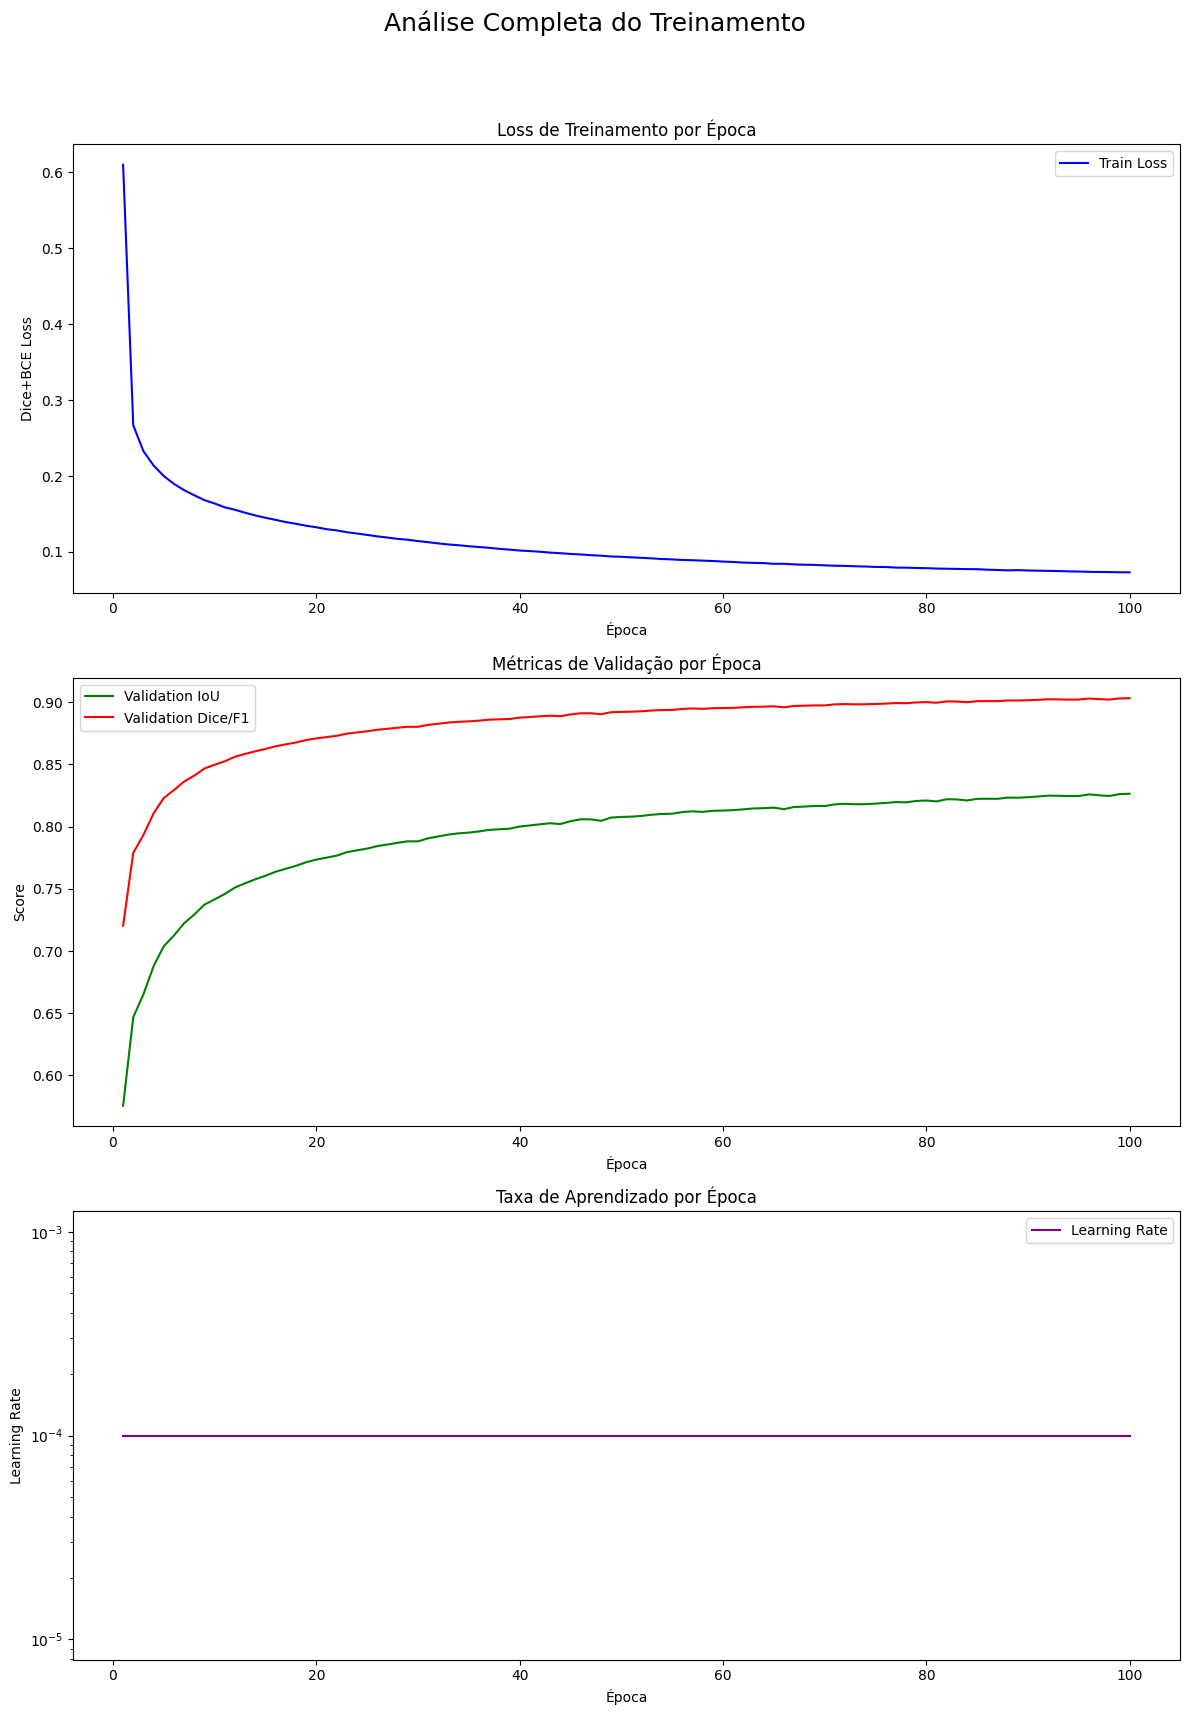


Calculando métricas finais detalhadas no conjunto de validação...


Calculando Métricas Finais: 100%|██████████| 1058/1058 [01:04<00:00, 16.50it/s]



      RESULTADOS FINAIS DO MELHOR MODELO
IoU         : 0.8265
Dice/F1     : 0.9033
Precision   : 0.9487
Recall      : 0.8630

Gerando visualizações de predições do melhor modelo...


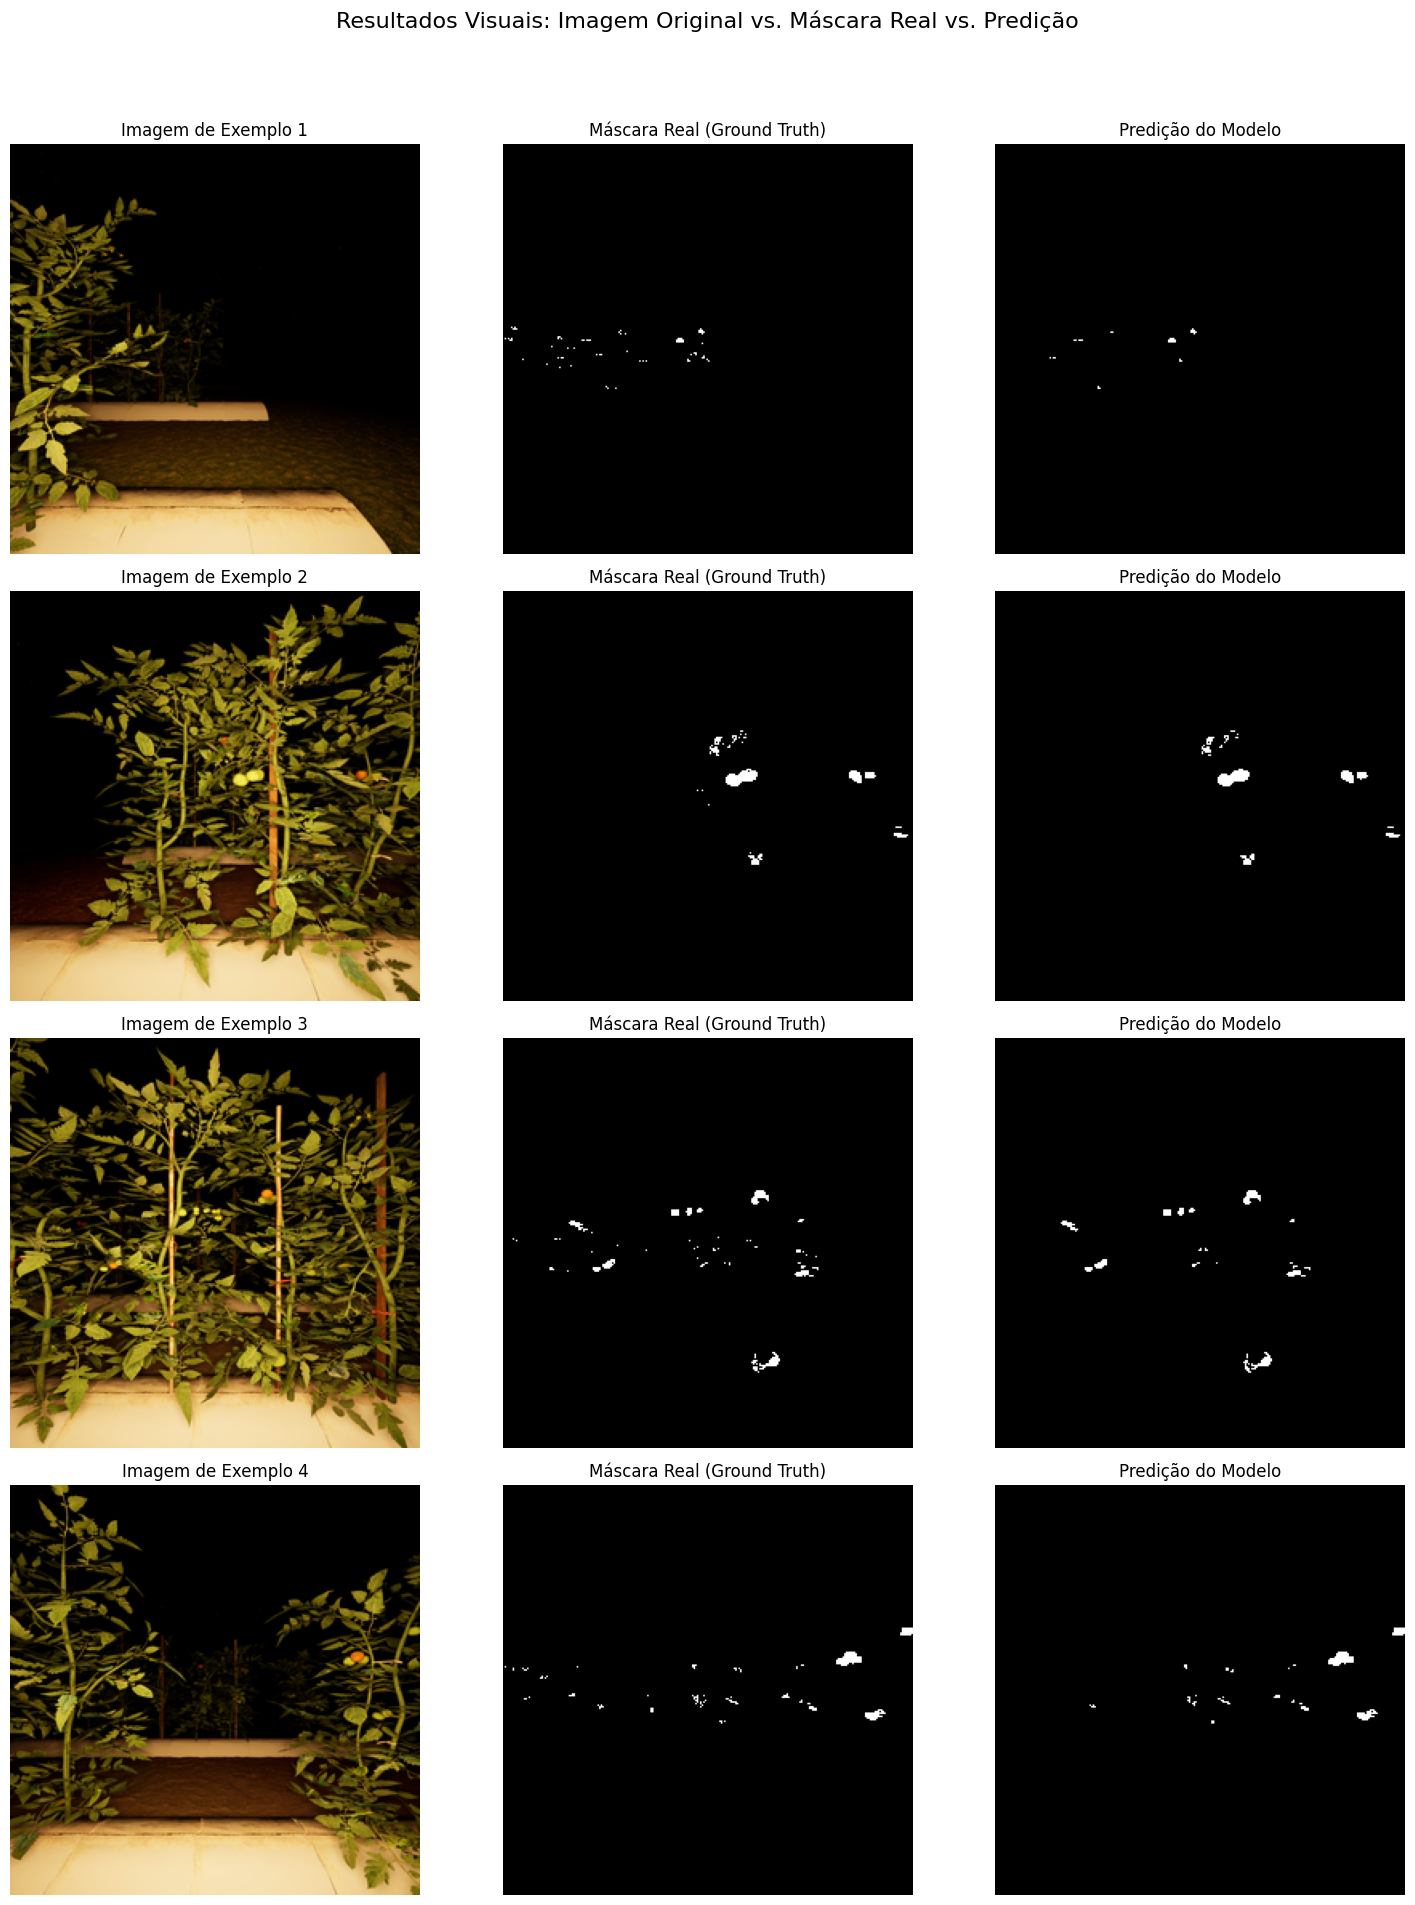

In [9]:
# ===================================================================
# CÉLULA 11: ANÁLISE FINAL, GRÁFICOS E MÉTRICAS (SUBSTITUIR)
# ===================================================================

# --- 1. CARREGAR DADOS E O MELHOR MODELO ---
print(f"Carregando o melhor modelo salvo de '{MODEL_SAVE_PATH}'...")
# Recria a arquitetura do modelo para carregar os pesos
analysis_model = UNET(in_channels=3, out_channels=1).to(DEVICE)
analysis_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
analysis_model.eval() # Coloca o modelo em modo de avaliação definitivo

print(f"Carregando log de treinamento de '{CSV_LOG_PATH}'...")
log_df = pd.read_csv(CSV_LOG_PATH)


# --- 2. GERAR GRÁFICOS DE TREINAMENTO ---
print("Gerando gráficos de treinamento...")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise Completa do Treinamento', fontsize=18)

# Gráfico 1: Loss de Treino
sns.lineplot(x='epoch', y='train_loss', data=log_df, ax=ax1, color='blue', label='Train Loss')
ax1.set_title('Loss de Treinamento por Época')
ax1.set_xlabel('Época')
ax1.set_ylabel('Dice+BCE Loss')

# Gráfico 2: Métricas de Validação
sns.lineplot(x='epoch', y='val_iou', data=log_df, ax=ax2, color='green', label='Validation IoU')
sns.lineplot(x='epoch', y='val_dice', data=log_df, ax=ax2, color='red', label='Validation Dice/F1')
ax2.set_title('Métricas de Validação por Época')
ax2.set_xlabel('Época')
ax2.set_ylabel('Score')
ax2.legend()

# Gráfico 3: Taxa de Aprendizado
sns.lineplot(x='epoch', y='learning_rate', data=log_df, ax=ax3, color='purple', label='Learning Rate')
ax3.set_title('Taxa de Aprendizado por Época')
ax3.set_xlabel('Época')
ax3.set_ylabel('Learning Rate')
ax3.set_yscale('log') # Escala logarítmica para ver melhor as quedas

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 3. CÁLCULO DE MÉTRICAS FINAIS DETALHADAS ---
def calculate_final_metrics(loader, model, device):
    print("\nCalculando métricas finais detalhadas no conjunto de validação...")
    dice_scores, iou_scores, precisions, recalls = [], [], [], []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Calculando Métricas Finais"):
            x, y = x.to(device), y.to(device)
            if len(y.shape) == 3: y = y.unsqueeze(1)
            
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
            tp = (preds * y).sum()
            fp = ((1 - y) * preds).sum()
            fn = (y * (1 - preds)).sum()
            
            precision = (tp + 1e-6) / (tp + fp + 1e-6)
            recall = (tp + 1e-6) / (tp + fn + 1e-6)
            dice = (2 * tp + 1e-6) / (2 * tp + fp + fn + 1e-6)
            iou = (tp + 1e-6) / (tp + fp + fn + 1e-6)
            
            precisions.append(precision.item())
            recalls.append(recall.item())
            dice_scores.append(dice.item())
            iou_scores.append(iou.item())

    final_metrics = {
        "IoU": np.mean(iou_scores),
        "Dice/F1": np.mean(dice_scores),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls)
    }
    return final_metrics

final_metrics = calculate_final_metrics(val_loader, analysis_model, DEVICE)


# --- 4. EXIBIR TABELA DE RESULTADOS FINAIS ---
print("\n" + "="*40)
print("      RESULTADOS FINAIS DO MELHOR MODELO")
print("="*40)
for metric, value in final_metrics.items():
    print(f"{metric:<12}: {value:.4f}")
print("="*40 + "\n")


# --- 5. VISUALIZAÇÃO QUALITATIVA DAS PREDIÇÕES ---
print("Gerando visualizações de predições do melhor modelo...")
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
val_images, val_masks = next(iter(val_loader))
num_images = min(5, len(val_images))

fig, axs = plt.subplots(num_images, 3, figsize=(15, num_images * 5))
fig.suptitle('Resultados Visuais: Imagem Original vs. Máscara Real vs. Predição', fontsize=16)

for i in range(num_images):
    image_tensor = val_images[i].to(DEVICE)
    true_mask_np = val_masks[i].squeeze().cpu().numpy()
    
    with torch.no_grad():
        pred_mask = analysis_model(image_tensor.unsqueeze(0))
        pred_mask = torch.sigmoid(pred_mask)
        pred_mask_np = (pred_mask > 0.5).float().squeeze().cpu().numpy()

    image_display = inv_normalize(image_tensor).cpu().permute(1, 2, 0).numpy()

    axs[i, 0].imshow(np.clip(image_display, 0, 1))
    axs[i, 0].set_title(f"Imagem de Exemplo {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_mask_np, cmap='gray')
    axs[i, 1].set_title("Máscara Real (Ground Truth)")
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_mask_np, cmap='gray')
    axs[i, 2].set_title("Predição do Modelo")
    axs[i, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()